# <font color='seablue'> **Optimisation linéaire et problèmes de graphes** </font> 

> **Note:** *ce notebook a été écrit essentiellement pour celles et ceux qui ont suivis le cours LINMA1702 - Modèles et méthodes d'optimisation I et qui voudraient faire le lien entre les problèmes de graphes vus au cours et l'optimisation linéaire.* 

## *Introduction*

Parmi l'ensemble des problèmes classiques de graphes que vous avez vus dans ce cours, certains d'entre-eux peuvent être résolus en les reformulant comme des problèmes d'optimisation linéaires en nombre entier.

Or, comme mentionné dans le cours LINMA1702 - Modèles et méthodes d'optimisation, certains des problèmes en nombres entiers font partie de la classe des problèmes "relaxables", c'est-à-dire tels que les variables imposées comme prenant des valeurs entières $x \in \mathbb{Z}^n$ peuvent être remplacées par des variables réelles $x \in \mathbb{R}^n$ sans que cela ne change la solution.

> **Remarque:** *Plusieurs résultats démontrés dans le cours de Master LINMA2450 - Combinatorial optimization permettent de déterminer les conditions pour qu'une telle relaxation soit possible. Cela demande notamment d'introduire la notion de matrices totalement unimodulaires, aussi appelées matrices TU (cf. https://en.wikipedia.org/wiki/Unimodular_matrix). Ainsi, dans ce notebook, nous nous contenterons de dire qu'un problème est relaxable sans en donner la démonstration.*

Une fois le problème en nombre entier relaxé sous la forme d'un programme linéaire, une méthode de résolution telle que l'algorithme du simplexe vu dans le cours LINMA1702 - Modèles et méthodes d'optimisation I peut alors être appliquée pour calculer de manière efficace la solution recherchée.

Un autre aspect intéressant concerne la dualité entre problèmes de graphes tels que $\texttt{couplage max}$ - $\texttt{couverture min}$. En fait, il s'avère que (sous certaines conditions) ces problèmes sont également duaux au sens de l'optimisation linéaire.


In [11]:
import matplotlib.pyplot as plt
# Librarie Python pour l'optimisation linéaire et l'optimisation en nombre entier
import mip 

# Utilisé pour générer et dessiner les graphes, et pour calculer la matrice d'incidence
import networkx as nx

## *Problèmes de couplage - couverture* 

Prenons par exemple le problème de $\texttt{couplage max}$ sur un graphe $G = (V, E)$ tel que $|V| = n$ et $|E| = m$. Soit $M \in \{0, 1\}^{n \times m}$ la matrice d'incidence du graphe et $\mathcal{M}$ est le couplage maximum recherché. On définit alors la variable indicatrice associée à ce couplage comme :
$$
x_j = \begin{cases}
1 & \text{ si } e_j \in \mathcal{M} \\
0 & \text{ sinon. }
\end{cases}
$$

Le problème de  $\texttt{couplage max}$ peut s'écrire sous la forme du programme linéaire suivant :
$$
\begin{align*}
\max_x&\ 1_m^T x \\
\text{ s.c. } & M x \leq 1_n \\
& x \in \{0, 1\}^m
\end{align*}
$$

où on note $1_n = \begin{pmatrix} 1 & \cdots & 1\end{pmatrix}^T \in \mathbb{R}^n$.
Intuitivement, la fonction objectif $f(x) = 1_m^T x$ représente la cardinalité du couplage $|\mathcal{M}|$ que l'on souhaite maximiser. 
Ensuite, écrire 
$${\color{tomato}M} {\color{skyblue}x} \leq {\color{springgreen}1_n}$$
revient en fait à dire que, <font color='springgreen'> chacun des noeuds </font> du graphe ne peuvent <font color='tomato'> être incidents  </font> au maximum qu'à <font color='skyblue'> une arête du couplage </font>. (En effet, si un noeud du graphe correspondant à la $i^{ème}$ entrée du vecteur $1_n$ était incident à 2 arêtes du couplage, alors on aurait $[M x]_i = 2$.)

En suivant les règles d'une table pour obtenir le dual d'un programme linéaire, celui-ci s'écrit comme 
$$
\begin{align*}
\min_y &\ 1_n^T y \\
\text{ s.c. } & M^T y \geq 1_m \\
& y \in \{0, 1\}^n
\end{align*}
$$
Ce dual correspond exactement à la reformulation "optimisation linéaire" du problème $\texttt{couverture min}$.
La variable $y$ est alors interprétée comme une variable indicatrice associée à la couverture de noeud minimale $\mathcal{K}$ :
$$
y_i = \begin{cases}
1 & \text{ si } v_i \in \mathcal{K} \\
0 & \text{ sinon. }
\end{cases}
$$

En effet, avec cette définition, l'objectif $g(y) = 1_n^T y$ représente la cardinalité de la couverture $|\mathcal{K}|$, que l'on souhaite minimiser. De plus, la contrainte 
$${\color{tomato}M^T} {\color{skyblue}y} \geq {\color{springgreen}1_m}$$
 impose que <font color='skyblue'> l'ensemble des noeuds de la couverture </font> soient  <font color='tomato'> incidents à </font> chacune des <font color='springgreen'> arêtes du graphe au moins une fois. </font>

En fait, on peut montrer que **si le graphe est biparti**, les problèmes $\texttt{couplage max}$ - $\texttt{couverture min}$ appartiennent à cette fameuse classe de problèmes relaxables. Cela fait sens vu ce que nous dit le **théorème de König dans le chapitre 5 des notes de cours !** Si $G$ est biparti, les contraintes binaires $x \in \{0, 1\}^m$, $y \in \{0, 1\}^n$ peuvent donc être remplacées respectivement par $0 \leq x \leq 1$ et $0 \leq y \leq 1$ sans que cela ne modifie le résultat.

#### *Implémentation des programmes linéaires avec mip*

Ci-dessous est fourni une implémentation avec mip des programmes linéaires précédemment introduits. Notez qu'en pratique, lorsque l'on manipule de grands graphes, il ne sera pas recommandé de construire la matrice d'incidence explicitement... Une réécriture des contraintes sera alors nécessaire pour minimiser le nombre d'opérations arithmétiques, mais cela sort du cadre de ce notebook.

In [12]:
def maxCouplage(M, relaxation_LP=True):
    model = mip.Model('Couplage', sense=mip.MAXIMIZE, solver_name=mip.CBC)
    if relaxation_LP: x = model.add_var_tensor((M.shape[1],), ub=1, lb=0, name='y')
    else:             x = model.add_var_tensor((M.shape[1],), name='y', var_type=mip.BINARY)
    model.objective = mip.maximize(mip.xsum(x))
    for i in range(M.shape[0]):
         model +=  mip.xsum(M[i,:]*x) <= 1

    model.optimize()
    return model, x

def minCouverture(M, relaxation_LP=True):
    model = mip.Model('Couverture', sense=mip.MINIMIZE, solver_name=mip.CBC)
    if relaxation_LP: y = model.add_var_tensor((M.shape[0],), ub=1, lb=0, name='y')
    else:             y = model.add_var_tensor((M.shape[0],), name='y', var_type=mip.BINARY)
    model.objective = mip.minimize(mip.xsum(y))
    for j in range(M.shape[1]):
         model +=  mip.xsum(M[:,j]*y) >= 1
    model.optimize()
    return model, y

#### *Exemple 1*

On se propose d'utiliser cette méthode sur un petit exemple. Ce graphe est biparti.

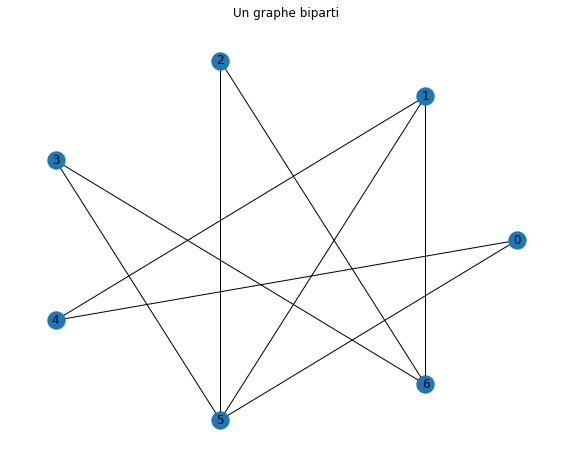

In [13]:
myGraph = nx.complete_bipartite_graph(4, 3)
myGraph.remove_edge(4, 2)
myGraph.remove_edge(4, 3)
myGraph.remove_edge(0, 6)

plt.figure(figsize=(10,8))
plt.title("Un graphe biparti")
nx.draw_circular(myGraph, with_labels=True)
plt.show()

# Calcul de la matrice d'incidence
M = nx.incidence_matrix(myGraph).toarray()

Couplage max: x = [0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]
Couverture min: y = [0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0]


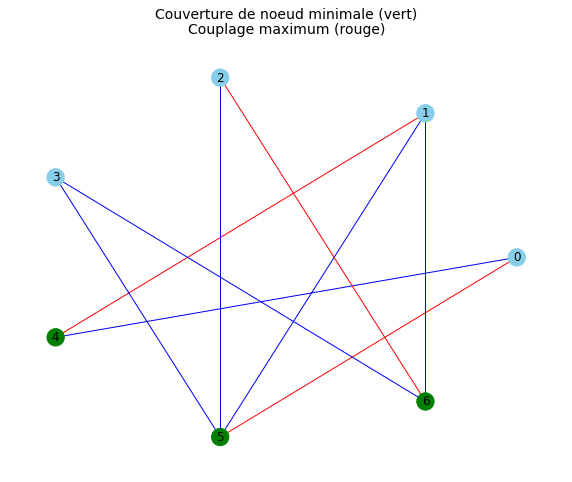

In [14]:
model_couplage, x = maxCouplage(M)
couplage_color = ['red' if i.x else 'blue' for i in x]
print("Couplage max: x =", [i.x for i in x])

model_couverture, y = minCouverture(M)
couverture_color = ['green' if j.x else 'skyblue' for j in y]
print("Couverture min: y =", [j.x for j in y])

plt.figure(figsize=(10,8))
plt.title("Couverture de noeud minimale (vert)\nCouplage maximum (rouge)", fontsize=14)
nx.draw_circular(myGraph, with_labels=True, node_color=couverture_color, edge_color=couplage_color)
plt.show()

Vu que le couplage maximal et la couverture minimale ont la même taille, nous sommes certains (par dualité faible) que la solution est optimale.

#### *Exemple 2*

Regardons maintenant ce qu'il se passe pour un graphe qui n'est pas biparti.

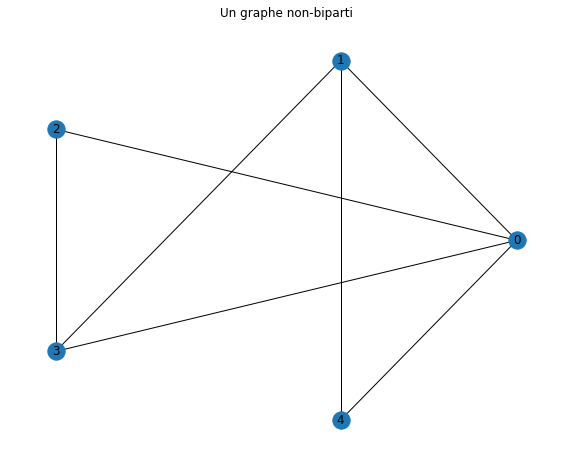

In [15]:
myGraph = nx.complete_graph(5)
myGraph.remove_edge(4, 2)
myGraph.remove_edge(4, 3)
myGraph.remove_edge(1, 2)

plt.figure(figsize=(10,8))
plt.title("Un graphe non-biparti")
nx.draw_circular(myGraph, with_labels=True)
plt.show()

# Calcul de la matrice d'incidence
M = nx.incidence_matrix(myGraph).toarray()

In [16]:
model_couplage, x = maxCouplage(M)
couplage_color = ['red' if i.x else 'blue' for i in x]
print("Couplage max: x =", [i.x for i in x])

model_couverture, y = minCouverture(M)
couverture_color = ['green' if j.x else 'skyblue' for j in y]
print("Couverture min: y =", [j.x for j in y])

print("-"*50)
print("Taille du couplage (relaxé) :", sum(i.x for i in x))
print("Taille de la couverture (relaxée) :", sum(j.x for j in y))

Couplage max: x = [0.5, 0.0, 0.0, 0.5, 0.0, 0.5, 1.0]
Couverture min: y = [0.5, 0.5, 0.5, 0.5, 0.5]
--------------------------------------------------
Taille du couplage (relaxé) : 2.5
Taille de la couverture (relaxée) : 2.5


On observe que la solution obtenue n'est plus entière ! En effet, puisque le graphe n'est plus biparti, le problème n'est plus automatiquement relaxable. Comme mentionné dans la remarque de l'introduction, il faut alors regarder si la matrice $M$ satisfait la propriété TU.

Cependant, à partir de la solution relaxée, nous pouvons tout de même définir des bornes sur les solutions optimales des deux problèmes.
Ainsi, on peut dire que $$|\mathcal{M}| \leq |\mathcal{M}_{relaxé}| = 2.5 \text{ et } |\mathcal{K}| \geq |\mathcal{K}_{relaxée}| = 2.5.$$ 

Puisque, ces quantités doivent être entières, on peut même obtenir des bornes plus précises : 
$|\mathcal{M}| \leq 2$ et $|\mathcal{K}| \geq 3$.

En résolvant cette fois-ci le problème avec des variables binaires $x \in \{0, 1\}^m$ et $y \in \{0, 1\}^n$, on voit que $|\mathcal{M}| = 2$ et $|\mathcal{K}| = 3$.

Couplage max: x = [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0]
Couverture min: y = [1.0, 1.0, 1.0, 0.0, 0.0]
--------------------------------------------------
Taille du couplage : 2.0
Taille de la couverture : 3.0


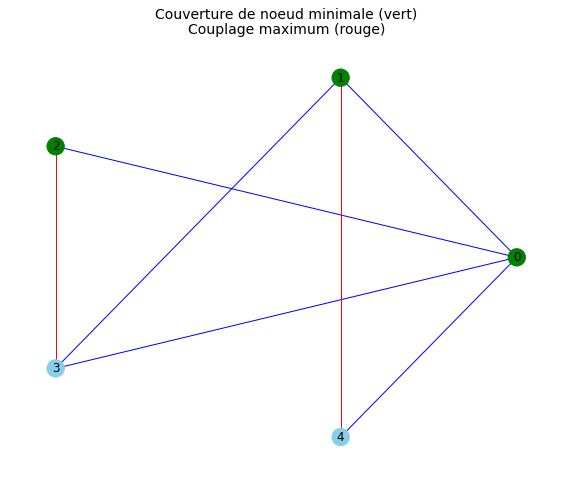

In [17]:
model_couplage, x = maxCouplage(M, relaxation_LP=False)
couplage_color = ['red' if i.x else 'blue' for i in x]
print("Couplage max: x =", [i.x for i in x])

model_couverture, y = minCouverture(M, relaxation_LP=False)
couverture_color = ['green' if j.x else 'skyblue' for j in y]
print("Couverture min: y =", [j.x for j in y])

print("-"*50)
print("Taille du couplage :", sum(i.x for i in x))
print("Taille de la couverture :", sum(j.x for j in y))

plt.figure(figsize=(10,8))
plt.title("Couverture de noeud minimale (vert)\nCouplage maximum (rouge)", fontsize=14)
nx.draw_circular(myGraph, with_labels=True, node_color=couverture_color, edge_color=couplage_color)
plt.show()

## *Problèmes du plus court chemin* 

On s'intéresse à présent au problème de plus court chemin dans un graphe dirigé et pondéré. On note ce plus court chemin $P$.

On définit la variable indicatrice associée au chemin $P$ :
$$
x_j = \begin{cases}
1 & \text{ si } e_j \in P\\
0 & \text{ sinon }
\end{cases}
$$

Si $c_j$ désigne le coût associé à une arête $e_j$, alors le problème de plus court chemin peut s'écrire comme suit :
$$
\begin{align*}
\min_{x} c^T x \\
\text{ s.c. } & Mx = b \\
& x\in \{0, 1\}^m
\end{align*}
$$
où $b = \begin{pmatrix} -1 \\ 0 \\ \vdots \\ 0 \\ 1\end{pmatrix}$ et $M$ représente la matrice d'incidence dirigée du graphe, i.e. $M_{ij} = -1$ si $e_j$ est une arête entrante dans $v_i$, $1$ si $e_j$ est une arête sortante de $v_i$ et $0$ sinon.

Intuitivement, $Mx = b$ correspond à une contrainte de conservation du flux. Lorsque je parcours mon chemin, je dois forcément arriver en un noeud $v_i$ donné du chemin en empruntant une arête entrante $(M_{ij} = -1)$ et sortir du noeud en empruntant une arête sortante $(M_{ij} = 1)$. Le flot net aux noeuds intermédiaires est donc nul ($b_i = 0$ pour tout noeud intermédiaire $v_i$ du chemin). Seuls le noeud source et le noeud puit ont une flot non nul. C'est pourquoi le vecteur $b$ contient un $-1$ et un $1$ en première et dernière entrée.

Notez que le problème de plus court chemin peut être vu comme un cas particulier du problème de flot. De plus, le problème de flot fait partie de la catégorie des problèmes relaxables. Ainsi, la contrainte binaire peut être remplacée par $x\in [0, 1]^m$.

## *Problème dual*

Le problème de plus court chemin admet également un problème dual :
$$
\begin{align*}
\max_{y} &\ b^T y \\
\text{ s.c. } & M^T y \leq c \\
\end{align*}
$$

Ce problème est interprété comme une maximisation du potentiel entre le noeud source et le noeud puit.

Maximiser $b^T y = y_{1} - y_{n}$ revient donc à maximiser la différence de potentiel entre le noeud source et le noeud puit.

De plus, la contrainte ${\color{skyblue} M^T y} \leq {\color{springgreen}c}$ indique que la  <font color='skyblue'> différence de potentiel entre 2 noeuds incidents à une même arête </font> ne peut pas dépasser une certaine <font color='springgreen'> capacité </font> correspondant au poids de l'arête.

In [37]:
def shortestPath(M, c=1, start=1, end=8):
    start -= 1
    end -= 1
    model = mip.Model('Couplage', sense=mip.MINIMIZE, solver_name=mip.CBC)
    x = model.add_var_tensor((M.shape[1],), ub=1, lb=0, name='x')
    model.objective = mip.minimize(mip.xsum(c*x))
    
    model +=  mip.xsum(M[start,:]*x) == -1
    for i in set(range(1, M.shape[0]-1))-{start, end}:
         model += mip.xsum(M[i,:]*x) == 0
    model += mip.xsum(M[end,:]*x) == 1

    model.optimize()
    return model, x

def PotentialNodes(M, c=1, start=1, end=8):
    start -= 1
    end -= 1
    model = mip.Model('Couplage', sense=mip.MAXIMIZE, solver_name=mip.CBC)
    y = model.add_var_tensor((M.shape[0],), name='x')
    model.objective = mip.maximize(y[start] - y[end])
    for j in range(M.shape[1]):
         model += mip.xsum(M[:,j]*y) <= c

    model.optimize()
    return model, y

In [38]:
# Calcul de la matrice d'incidence
myGraph = nx.Graph().to_directed()

myGraph.add_edge(1, 4); myGraph.add_edge(4, 1)
myGraph.add_edge(2, 3); myGraph.add_edge(3, 2)
myGraph.add_edge(3, 4); myGraph.add_edge(4, 3)

myGraph.add_edge(4, 5); myGraph.add_edge(5, 4)
myGraph.add_edge(5, 6); myGraph.add_edge(6, 5)

myGraph.add_edge(6, 3); myGraph.add_edge(3, 6)

myGraph.add_edge(6, 7); myGraph.add_edge(7, 6)
myGraph.add_edge(7, 8); myGraph.add_edge(8, 7)
M_oriented = nx.incidence_matrix(myGraph, nodelist=list(range(1, 9)), oriented=True).toarray()
print(M_oriented)

[[-1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  1. -1. -1. -1.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1. -1. -1. -1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0. -1. -1.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  1. -1. -1. -1.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1. -1.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. -1.]]


Plus court chemin: x = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0]
Potentiels aux noeuds optimaux: y = [1.0, 1.999999999999, 0.9999999999989999, 0.0, 1.0, 2.0, 3.0, 4.0]
Différence de potentiel entre 8 et 4 trouvée:  4.0


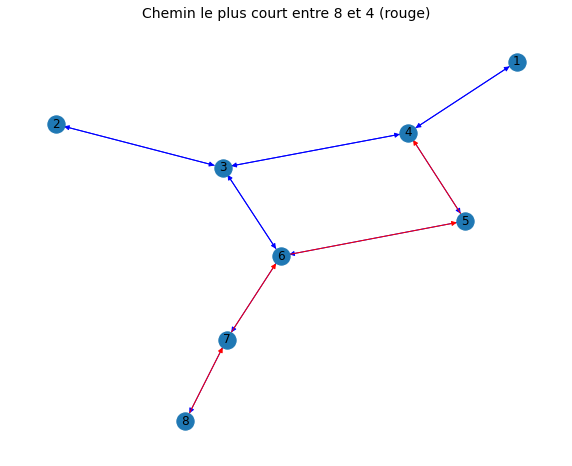

In [40]:
start = 8; end = 4
sp_model, x = shortestPath(M_oriented, start=start, end=end)
sp_color = ['red' if i.x else 'blue' for i in x]
print("Plus court chemin: x =", [i.x for i in x])

pn_model, y = PotentialNodes(M_oriented, start=start, end=end)
pn_sol = [j.x for j in y]
print("Potentiels aux noeuds optimaux: y =", pn_sol)
print(f"Différence de potentiel entre {start} et {end} trouvée: ", y[start-1].x - y[end-1].x)

plt.figure(figsize=(10,8))
plt.title(f"Chemin le plus court entre {start} et {end} (rouge)", fontsize=14)
nx.draw_kamada_kawai(myGraph, with_labels=True, edge_color=sp_color)
plt.show()

## *Conclusion*

En lisant ce notebook, vous avez pu découvrir comment les problèmes classiques de graphe pouvaient être résolus par des méthodes d'optimisation linéaire tel que l'algorithme du simplexe. Il vient alors une question naturelle : quelle méthode est la plus efficace en pratique ? Faut-il mieux utiliser des algorithmes de graphes tels que l'algorithme hongrois (pour le couplage) ou de Dijkstra (pour le plus court chemin), ou bien l'optimisation linéaire est-elle plus rapide ? 

Tout d'abord, il est intéressant de noter que les algorithmes de graphes peuvent être vus comme des cas particuliers de l'algorithme du simplexe. En effet, considèrons par exemple l'algorithme hongrois. Intuitivement, à une itération $k$ de l'algorithme, nous partons d'un certain couplage $\mathcal M_k$ que nous augmentons de $1$ en taille en identifiant un chemin $\mathcal M_k$-augmentant. On obtient ainsi un nouveau couplage $\mathcal M_{k+1}$ de taille $|\mathcal M_{k+1}| = |\mathcal M_k| + 1$. 

En suivant une interprétation optimisation linéaire, chaque couplage $\mathcal M_k$ peut être vu comme un noeud du polyèdre des couplages (défini par la contrainte linéaire $Mx \leq 1_n$). Ainsi, en mettant itérativement à jour le couplage selon la règle décrite ci-dessus, nous parcourons les noeuds du polyèdre jusqu'à atteindre le noeud optimal. L'algorithme hongrois revient, donc d'une certaine manière, à effectuer un simplexe mais avec une règle de pivots (mise à jour des variables dans la base et des variables hors base) bien précise qui tient compte de la structure du problème. 

On s'attend donc à ce que les méthodes de graphes soient plus rapides que l'algorithme du simplexe, vu qu'elles ont été construites pour résoudre un problème bien spécifique et non une grande classe de problèmes comme celle des programmes linéaires.

Cependant, les problèmes d'optimisation linéaire peuvent être aujourd'hui résolus par des solvers numériques avec une très grande efficacité [1] utilisant des astuces telles que le calcul en parallèle, la méthode des plans sécants [2], la génération de colonne [3], ...
Dès lors, en fonction de la dimension du problème, il arrive que l'optimisation linéaire soit plus rapide qu'un algorithme de graphe, surtout  si ce dernier est implémenté à la main.

## *Références*

- [1] https://math.stackexchange.com/questions/1774954/solving-linear-optimization-problem-with-shortest-path-algorithm, consulté le 02-12-2023
- [2] https://en.wikipedia.org/wiki/Cutting-plane_method, consulté le 02-12-2023
- [3] https://en.wikipedia.org/wiki/Column_generation, consulté le 02-12-2023
- [4] https://fr.wikipedia.org/wiki/Probl%C3%A8me_de_plus_court_chemin, consulté le 02-12-2023
- [5] https://en.wikipedia.org/wiki/Unimodular_matrix, consulté le 02-12-2023
- [6] https://www.python-mip.com/, consulté le 02-12-2023
- [7] F. Glineur, LINMA1702 - Modèles et méthodes d'optimisation I, UCLouvain, 2021
- [8] G. Grapiglia, J. Hendrickx, LINMA2450 - Combinatorial optimization, UCLouvain, 2022
